##Import library yang akan digunakan

In [ ]:
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import utils
from google.colab.patches import cv2_imshow
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##Download Dataset From Kaggle

In [ ]:
#Mount your GDrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

#Upload kaggle.json (Kaggle API Token)
#You can download it by create new API Token from your kaggle account

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"auliarasyidrasyid","key":"41edb886e9ccdf9cf283f08739f6dc29"}'}

In [ ]:
#Make sure kaggle.json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 69 May 31 11:27 kaggle.json


In [ ]:
#Install kaggle API client
!pip install -q kaggle

In [ ]:
#Download and unzip the dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/110472418_87b6a3aa98_m.jpg  
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b

##Load dan Split dataset

###Membuat directory untuk training dan testing setiap class

In [ ]:
try:
    os.mkdir("/content/flowers-cnn")
    os.mkdir("/content/flowers-cnn/training")
    os.mkdir("/content/flowers-cnn/testing")
    os.mkdir("/content/flowers-cnn/training/sunflower")
    os.mkdir("/content/flowers-cnn/training/daisy")
    os.mkdir("/content/flowers-cnn/training/dandelion")
    os.mkdir("/content/flowers-cnn/testing/sunflower")
    os.mkdir("/content/flowers-cnn/testing/daisy")
    os.mkdir("/content/flowers-cnn/testing/dandelion")
except OSError:
    pass

###Fungsi untuk split dataset

In [ ]:
def split_data(SOURCE, TRAINING, TESTING):
    filelist = [ f for f in os.listdir(TRAINING)]
    for f in filelist:
        os.remove(os.path.join(TRAINING, f))
    filelist = [ f for f in os.listdir(TESTING)]
    for f in filelist:
        os.remove(os.path.join(TESTING, f))
    the_files=os.listdir(SOURCE)
    chosen=random.sample(the_files,100) #Memilih 100 file secara acak
    chosen_training=random.sample(chosen,80) #Mengambil 80 dari 100 file yang terpilih untuk menjadi training set
    for i in the_files:
        if i in chosen:
            if i in chosen_training:
                copyfile(SOURCE+i, TRAINING+i)
            else:
                copyfile(SOURCE+i, TESTING+i)

80
20


###Memanggil fungsi split dataset untuk setiap class

In [ ]:
sunflower_dir="/content/flowers/sunflower/"
sunflower_training_dir="/content/flowers-cnn/training/sunflower/"
sunflower_testing_dir="/content/flowers-cnn/testing/sunflower/"
daisy_dir="/content/flowers/daisy/"
daisy_training_dir="/content/flowers-cnn/training/daisy/"
daisy_testing_dir="/content/flowers-cnn/testing/daisy/"
dandelion_dir="/content/flowers/dandelion/"
dandelion_training_dir="/content/flowers-cnn/training/dandelion/"
dandelion_testing_dir="/content/flowers-cnn/testing/dandelion/"

split_data(sunflower_dir,sunflower_training_dir,sunflower_testing_dir)
split_data(daisy_dir,daisy_training_dir,daisy_testing_dir)
split_data(dandelion_dir,dandelion_training_dir,dandelion_testing_dir)

print(len(os.listdir("/content/flowers-cnn/training/sunflower/")))
print(len(os.listdir("/content/flowers-cnn/training/daisy/")))
print(len(os.listdir("/content/flowers-cnn/training/dandelion/")))
print(len(os.listdir("/content/flowers-cnn/testing/sunflower/")))
print(len(os.listdir("/content/flowers-cnn/testing/daisy/")))
print(len(os.listdir("/content/flowers-cnn/testing/dandelion/")))

80
80
80
20
20
20


##Membuat sequential model untuk CNN

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(320, 240, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary() #Model memiliki 3 convpool layer

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 318, 238, 64)      1792      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 159, 119, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 157, 117, 64)      36928     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 78, 58, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 76, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 38, 28, 128)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 36, 26, 128)     

##Mendefinisikan Data Generator

In [ ]:
training_dir="/content/flowers-cnn/training/"
train_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(training_dir,
                                                    target_size=(320,240),
                                                    batch_size=10,
                                                    class_mode='categorical')
testing_dir = "/content/flowers-cnn/testing/"
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = validation_datagen.flow_from_directory(testing_dir,
                                                              target_size=(320,240),
                                                         batch_size=10,
                                                         class_mode='categorical')

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


##Melakukan training

In [ ]:
history = model.fit(train_generator, epochs=15, verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
24/24 [==============================] - 48s 2s/step - loss: 2.0039 - acc: 0.4000 - val_loss: 1.0856 - val_acc: 0.2833
Epoch 2/15
24/24 [==============================] - 47s 2s/step - loss: 1.0831 - acc: 0.4250 - val_loss: 1.0249 - val_acc: 0.4833
Epoch 3/15
24/24 [==============================] - 47s 2s/step - loss: 1.1089 - acc: 0.5333 - val_loss: 1.1142 - val_acc: 0.5500
Epoch 4/15
24/24 [==============================] - 47s 2s/step - loss: 0.9196 - acc: 0.6083 - val_loss: 0.9849 - val_acc: 0.4833
Epoch 5/15
24/24 [==============================] - 47s 2s/step - loss: 0.8785 - acc: 0.6042 - val_loss: 0.9605 - val_acc: 0.4500
Epoch 6/15
24/24 [==============================] - 47s 2s/step - loss: 0.8124 - acc: 0.6917 - val_loss: 1.0568 - val_acc: 0.6000
Epoch 7/15
24/24 [==============================] - 47s 2s/step - loss: 0.5881 - acc: 0.7833 - val_loss: 1.3568 - val_acc: 0.5000
Epoch 8/15
24/24 [==============================] - 47s 2s/step - loss: 0.4088 - acc: 0.84

##Plot accuracy dan loss untuk training dan validation

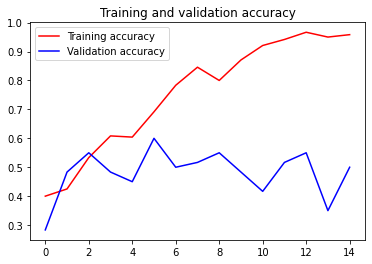

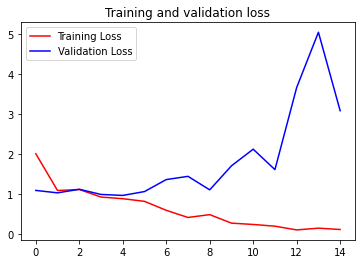

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()